Num EBs:		 3485
Num EBs are SBs:	 200


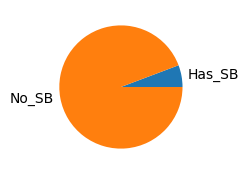

In [17]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt

df = pd.read_csv("pht_vsx_eb_with_sb.csv", dtype={
    "GAIA_Source": "uint64",  # ensure it's large enough
    "NSS_Flags": "Int64",  # make it nullable int
    })
df = df[pd.notna(df["VSX_Period"])]  # compensate a bug that some rows has no period in VSX
df["Period_Ratio_EB_SB"] = df["VSX_Period"] / df["NSS_Per"]
df["Period_Delta_EB_SB"] = np.abs(df["VSX_Period"] - df["NSS_Per"])

df["Has_SB"] = pd.notna(df["NSS_Per"])

df_m1 = df[df["Has_SB"]]  # those with SBs


print("Num EBs:\t\t", len(df))
print("Num EBs are SBs:\t", len(df_m1))

ax = plt.figure(figsize=(2, 2)).gca()
ax.pie(
    [ len(df_m1), len(df) - len(df_m1), ],
    labels=["Has_SB", "No_SB"],
    );

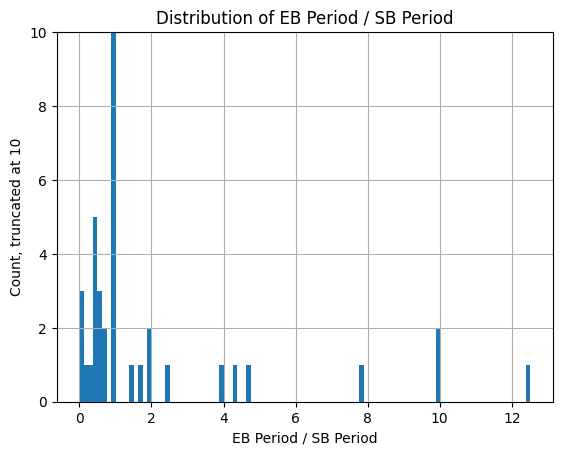

In [18]:
ax = df_m1["Period_Ratio_EB_SB"].hist(bins=100)
ax.set_ylim(0, 10);
ax.set_title("Distribution of EB Period / SB Period");
ax.set_xlabel("EB Period / SB Period");
ax.set_ylabel("Count, truncated at 10");

## List of targets with significant difference in EB period and SB period

In [19]:
# now exclude those that closely match EB period (ratio ~1, ~0.5 ~2)

def not_in_range(df, column, range_min, range_max):
    return df[~((range_min < df[column]) & (df[column] < range_max))]


df_m2 = df_m1
df_m2 = not_in_range(df_m2, "Period_Ratio_EB_SB", 0.99, 1.01)
df_m2 = not_in_range(df_m2, "Period_Ratio_EB_SB", 0.495, 0.505)
df_m2 = not_in_range(df_m2, "Period_Ratio_EB_SB", 1.98, 2.02)
df_m2 = not_in_range(df_m2, "Period_Delta_EB_SB", 0.0, 0.1)  # also exclude those the absolute difference is small

df_m2.sort_values(by="Period_Ratio_EB_SB", inplace=True)

print("Num. of targets with significant difference in EB / SB periods:", len(df_m2))
df_m2[["tic_id", "best_subject_id",
       "GAIA_Source", "VSX_OID", "VSX_Type",
       "VSX_Period", "NSS_Per", "Period_Ratio_EB_SB",
       "GAIA_sepsi", "GAIA_RUWE", "GAIA_e_RV",
       "NSS_Vcm", "NSS_Flags",
       ]].reset_index(drop=True)

Num. of targets with significant difference in EB / SB periods: 22


,tic_id,best_subject_id,GAIA_Source,VSX_OID,VSX_Type,VSX_Period,NSS_Per,Period_Ratio_EB_SB,GAIA_sepsi,GAIA_RUWE,GAIA_e_RV,NSS_Vcm,NSS_Flags
0,57297550,46378386,1352346392464295168,15668,EW,0.382230,292.867149,0.001305,10.0350,0.938,5.15,-35.901714,8192
1,440051305,38692422,385590588900489216,555463,EW,0.329674,63.305101,0.005208,6364.0000,15.197,0.86,-22.938943,0
2,273874851,37757104,2086448353089047808,162391,EA,2.045161,69.560975,0.029401,60.2470,1.289,25.59,-3.426411,8192
3,377192658,48941611,2153474753718586112,13758,EA/SD:,1.817239,8.450807,0.215037,21.6410,1.044,6.58,-9.860949,0
4,154453805,48949795,1149193614730258688,4756,EA,1.091739,3.354365,0.325468,84.3200,1.576,NaN,-4.956532,8388608
5,8444713,48223034,1329183358958814208,245383,E,4.423851,9.405972,0.470324,18.1890,1.151,2.40,-26.179448,0
6,276232142,48230723,495188361769736832,227827,EA,2.509867,5.236879,0.479268,7.5538,0.965,NaN,-0.826826,8388608
7,259260957,38693340,387290085984658176,241983,EA,9.574870,18.251149,0.524617,6.6326,0.894,2.96,-13.338238,0
8,316633520,48941874,4569662722672317440,106535,ED,2.540039,4.637713,0.547692,12.7370,0.945,2.86,0.085765,0
9,305832152,38703271,414938061776891264,6695,EA,1.543067,2.521366,0.611996,21.1430,1.033,NaN,2.543046,8388608


In [22]:
# df_m2.to_csv("multi_star_candidates_by_eb_sb_period_diff.csv", index=False)